In [2]:
import os, sys
import math
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from typing import Optional, List, Tuple, Dict, Union
from dataclasses import dataclass, field

script_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
for i in range(1, 5): # Check up to 4 levels up
    dir_up = os.path.abspath(os.path.join(script_dir, *(['..'] * i)))
    if dir_up not in sys.path:
        sys.path.append(dir_up)
    sys.path.append(os.path.join(dir_up, "QES", "general_python"))

try:
    import jax
    import jax.numpy as jnp
    import gymnasium as gym
    # for Flax
    import optax
    import flax.linen as nn
    from flax.training.train_state import TrainState
    from flax.linen.initializers import orthogonal
except ImportError as e:
    print("Please install the required packages: jax, jaxlib, gymnasium, optax, flax")
    sys.exit(1)
    
# common utilities for logging
try:
    from QES.general_python.common.flog import Logger, get_global_logger
    from QES.general_python.common.directories import Directories
    from QES.general_python.common.plot import Plotter
    from QES.Algebra.hamil_quadratic import QuadraticSelection
    from QES.general_python.physics.entropy_jax import vn_entropy_jax
    from QES.general_python.physics.density_matrix_jax import rho_jax, schmidt_jax
    from QES.general_python.physics.entropy import EntropyPredictions
except ImportError as e:
    print(f"Error importing custom modules (QES, extractors): {e}")
    print("Please ensure these modules are in the Python path and are JAX-compatible.")
    sys.exit(1)
    
# For reproducibility
# master_seed     = np.random.randint(0, 2**32 - 1) 
master_seed     = 42 # Or set a fixed seed
key             = jax.random.PRNGKey(master_seed)
np.random.seed(master_seed)

# Logger setup
logger          = get_global_logger()

In [60]:
iscpx       = False             # complex or real Hamiltonian
dtype_jax   = jnp.complex128 if iscpx else jnp.float64
dtype_np    = np.complex128 if iscpx else np.float64

# config and information
L           = 6                 # number of qubits
Nh          = 2**L              # number of states
Nblocks     = 6                # number of 'symmetry' blocks in the Hamiltonian
Gamma       = 6                # number of degeneracy manifolds
N           = Nh // Nblocks     # number of states in each block

# for the entanglement entropy
La          = L // 2            # number of qubits in the left partition
Lb          = L - La            # number of qubits in the right partition
dimA        = 2**La             # dimension of the left partition
dimB        = 2**Lb             # dimension of the right partition

@dataclass
class EntropyStats:
    values  : List[float]   = field(default_factory=list)
    indices : List[int]     = field(default_factory=list)
    maximum : float         = math.nan
    minimum : float         = math.nan
    mean    : float         = math.nan
    std     : float         = math.nan

config = {
    "SEED"          : master_seed,   
    # environment
    "ENV"           : {
        "Ns"            : L,        # number of qubits
        "Nh"            : Nh,       # number of states
        "Nblocks"       : Nblocks,  # number of 'symmetry' blocks in the Hamiltonian
        "N"             : N,        # number of states in each block
        "Gamma"        : Gamma,   # number of degeneracy manifolds
    },
    "BIPARTITION"   : {
        "La"            : La,       # number of qubits in the left partition
        "Lb"            : Lb,       # number of qubits in the right partition
        "f"             : La / L,   # fraction of the left partition
        "dimA"          : dimA,     # dimension of the left partition
        "dimB"          : dimB,     # dimension of the right partition
    },
}


### Design Random Matrix with specified degeneracy manifolds

In [61]:
def create_degenerate_block(n_states    : int,
                            eigenvalues : Optional[np.ndarray]  = None,
                            rng_seed    : Optional[int]         = None,
                            iscomplex   : bool                  = False) -> np.ndarray:

    if rng_seed is not None:
        np.random.seed(rng_seed)

    if eigenvalues is None:
        eigenvalues = np.random.uniform(-2, 2, size=n_states) # Random eigenvalues on the interval [-2, 2]

    # create a random unitary matrix to transform the eigenvalues
    if iscomplex:
        A = np.random.randn(n_states, n_states) + 1j * np.random.randn(n_states, n_states)
    else:
        A = np.random.randn(n_states, n_states)
        
    # QR decomposition to ensure orthogonality (or unitary for complex)
    Q, _ = np.linalg.qr(A)
    
    # create the block diagonal matrix with the eigenvalues
    block = Q @ np.diag(eigenvalues) @ Q.conj().T
    
    # ensure the block is Hermitian (or symmetric for real)
    if iscomplex:
        block = (block + block.conj().T) / 2
    else:
        block = (block + block.T) / 2
    
    # return the block matrix
    return block, eigenvalues, Q

def create_random_hamiltonian(L         : int, 
                            Nblocks     : int, 
                            iscomplex   : bool = False, 
                            eigenvalues : Optional[List[np.ndarray]] = None,
                            Gamma      : Optional[int] = None,
                            seeds       : Optional[List[int]] = None) -> np.ndarray:
    """
    Create a random Hamiltonian with specified degeneracy manifolds.
    
    Parameters:
    - L: Number of qubits (log2 of the number of states)
    - Nblocks: Number of symmetry blocks in the Hamiltonian
    - iscomplex: Whether to create a complex Hamiltonian
    - eigenvalues: Optional list of eigenvalues for each block. If None, random eigenvalues are generated.
    - seeds: Optional list of seeds for random number generation for each block. If None,
    
    Returns:
    - A random Hamiltonian as a numpy array.
    """
    
    Nh          = 2**L              # Total number of states
    N           = Nh // Nblocks     # Number of states in each block
    hamiltonian = np.zeros((Nh, Nh), dtype=np.complex128 if iscomplex else np.float64)
    
    if seeds is not None and len(seeds) != Nblocks:
        raise ValueError("Length of seeds must match Nblocks.")

    if eigenvalues is None:
        if Gamma is not None and Gamma != Nblocks:
            # Gamma is the number of degeneracy manifolds, not the number of blocks
            if Nblocks % Gamma != 0:
                raise ValueError("Nblocks must be a multiple of Gamma.")
            # number of distinct eigenvalues per block
            N_eigenvalues   = N // Gamma # if the same, this is = 1
            eigenvalues     = [np.random.uniform(-2, 2, size=N) for _ in range(Nblocks // Gamma)]
            # repeat each eigenvalue Gamma times to create the blocks
            eigenvalues     = eigenvalues * (Gamma // N_eigenvalues)
        else:
            # we assume the number of blocks is equal to the number of degeneracy manifolds
            eigenvalues = [np.random.uniform(-2, 2, size=N)] * Nblocks
    elif len(eigenvalues) != Nblocks:
        raise ValueError("Length of eigenvalues must match Nblocks.")
    
    for i in range(Nblocks):
        block, _, _             = create_degenerate_block(N, eigenvalues=eigenvalues[i], rng_seed=seeds[i], iscomplex=iscomplex)
        print(f"Block {i+1}/{Nblocks}: Eigenvalues = {eigenvalues[i]}")
        start_index             = i * N
        end_index               = start_index + N
        hamiltonian[start_index:end_index, start_index:end_index] = block
        
    # apply random unitary transformation to the Hamiltonian to mix the blocks
    if iscomplex:
        A = np.random.randn(Nh, Nh) + 1j * np.random.randn(Nh, Nh)
    else:
        A = np.random.randn(Nh, Nh)
    Q, _        = np.linalg.qr(A)
    hamiltonian = Q @ hamiltonian @ Q.conj().T
    
    return hamiltonian

In [62]:
hamil = create_random_hamiltonian(L, Nblocks, Gamma=Gamma, iscomplex=iscpx, seeds=list(range(Gamma)))
eigenvalues, eigenvectors = np.linalg.eigh(hamil)

eigenvalues, eigenvectors.dtype

Block 1/6: Eigenvalues = [ 0.24464707  0.79658022  1.76195374  1.35594139  1.53030748 -1.34504222
  1.1578906  -1.60482322  0.20920862 -1.69535393]
Block 2/6: Eigenvalues = [ 0.24464707  0.79658022  1.76195374  1.35594139  1.53030748 -1.34504222
  1.1578906  -1.60482322  0.20920862 -1.69535393]
Block 3/6: Eigenvalues = [ 0.24464707  0.79658022  1.76195374  1.35594139  1.53030748 -1.34504222
  1.1578906  -1.60482322  0.20920862 -1.69535393]
Block 4/6: Eigenvalues = [ 0.24464707  0.79658022  1.76195374  1.35594139  1.53030748 -1.34504222
  1.1578906  -1.60482322  0.20920862 -1.69535393]
Block 5/6: Eigenvalues = [ 0.24464707  0.79658022  1.76195374  1.35594139  1.53030748 -1.34504222
  1.1578906  -1.60482322  0.20920862 -1.69535393]
Block 6/6: Eigenvalues = [ 0.24464707  0.79658022  1.76195374  1.35594139  1.53030748 -1.34504222
  1.1578906  -1.60482322  0.20920862 -1.69535393]


(array([-1.69535393e+00, -1.69535393e+00, -1.69535393e+00, -1.69535393e+00,
        -1.69535393e+00, -1.69535393e+00, -1.60482322e+00, -1.60482322e+00,
        -1.60482322e+00, -1.60482322e+00, -1.60482322e+00, -1.60482322e+00,
        -1.34504222e+00, -1.34504222e+00, -1.34504222e+00, -1.34504222e+00,
        -1.34504222e+00, -1.34504222e+00, -6.09746162e-16, -1.68807863e-16,
         2.17928685e-16,  3.49691468e-16,  2.09208620e-01,  2.09208620e-01,
         2.09208620e-01,  2.09208620e-01,  2.09208620e-01,  2.09208620e-01,
         2.44647072e-01,  2.44647072e-01,  2.44647072e-01,  2.44647072e-01,
         2.44647072e-01,  2.44647072e-01,  7.96580216e-01,  7.96580216e-01,
         7.96580216e-01,  7.96580216e-01,  7.96580216e-01,  7.96580216e-01,
         1.15789060e+00,  1.15789060e+00,  1.15789060e+00,  1.15789060e+00,
         1.15789060e+00,  1.15789060e+00,  1.35594139e+00,  1.35594139e+00,
         1.35594139e+00,  1.35594139e+00,  1.35594139e+00,  1.35594139e+00,
         1.5

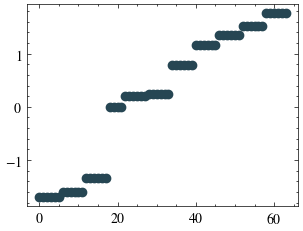

In [63]:
plt.plot(eigenvalues, 'o')

#### Prepare the degenerate eigenstates

In [64]:
def find_degenerate_manifolds(eigenvalues, decimals: int = 6):
    degeneracies = defaultdict(list)
    for i, eig in enumerate(eigenvalues):
        key = round(eig, decimals)
        degeneracies[key].append(i)
    return degeneracies

def find_degenerate_manifolds_sorted(eigenvalues, tol: float = 1e-8, decimals: int = 6):
    groups          = defaultdict(list)
    current_group   = [0]
    for i in range(1, len(eigenvalues)):
        if abs(eigenvalues[i] - eigenvalues[i - 1]) < tol:
            current_group.append(i)
        else:
            key             = round(eigenvalues[i - 1], decimals)
            groups[key]     = current_group
            current_group   = [i]
    key             = round(eigenvalues[-1], decimals)
    groups[key]     = current_group  # add the last group
    return groups

degeneracies = find_degenerate_manifolds_sorted(eigenvalues)
# degeneracies = find_degenerate_manifolds(eigenvalues)
degeneracies

defaultdict(list,
            {-1.695354: [0, 1, 2, 3, 4, 5],
             -1.604823: [6, 7, 8, 9, 10, 11],
             -1.345042: [12, 13, 14, 15, 16, 17],
             0.0: [18, 19, 20, 21],
             0.209209: [22, 23, 24, 25, 26, 27],
             0.244647: [28, 29, 30, 31, 32, 33],
             0.79658: [34, 35, 36, 37, 38, 39],
             1.157891: [40, 41, 42, 43, 44, 45],
             1.355941: [46, 47, 48, 49, 50, 51],
             1.530307: [52, 53, 54, 55, 56, 57],
             1.761954: [58, 59, 60, 61, 62, 63]})

In [65]:
entropies           = {
    "original"      : EntropyStats(),
    "mix_states"    : EntropyStats(),
    "mix_dens_mat"  : EntropyStats()
}

In [66]:
# Select a random manifold from the degeneracies
manifold                = np.random.choice(list(degeneracies.keys()))
manifold_indices        = degeneracies[manifold]
logger.info(f"Selected manifold: {manifold}")

# original states
manifold_states         = eigenvectors[:, manifold_indices]
manifold_org_jax        = jax.numpy.array(manifold_states)
logger.info(f"Original states shape: {manifold_org_jax.shape}")

# save the original states
entropies["original"]   = EntropyStats()  # reset for original states
for state in manifold_org_jax.T:
    schmidt_values, _       = schmidt_jax(state, dimA, dimB, use_eig=False)
    entropy                 = vn_entropy_jax(schmidt_values)
    entropies["original"].values.append(float(entropy))
entropies["original"].maximum       = max(entropies["original"].values)
entropies["original"].minimum       = min(entropies["original"].values)
entropies["original"].mean          = np.mean(entropies["original"].values)
entropies["original"].std           = np.std(entropies["original"].values)
entropies["original"].indices       = manifold_indices
logger.info(f"Original entropies: {entropies['original'].values}")

29_07_2025_18-55_36 [INFO] Selected manifold: -1.695354
29_07_2025_18-55_36 [INFO] Original states shape: (64, 6)
29_07_2025_18-55_36 [INFO] Original entropies: [1.6089175504281858, 1.6221296485671712, 1.443545462314221, 1.472824023872915, 1.6477593232208663, 1.6057340574638586]


In [67]:
# mix the states using Haar random unitaries
entropies["mix_states"] = EntropyStats()  # reset for mixed states
gamma_mix               = config["ENV"]["Gamma"]
print(f"Mixing states with Haar random unitary (gamma={gamma_mix})")
if iscpx:
    haar_unitary            = jnp.array(QuadraticSelection.haar_random_unitary(gamma=gamma_mix), dtype=jnp.complex128)
else:
    # take simple random unitary if not complex
    # this is a Haar random unitary for real matrices
    haar_unitary            = jnp.array(QuadraticSelection.haar_random_unitary_real(gamma=gamma_mix), dtype=jnp.float64)
mainifold_mix_st_jax    = manifold_org_jax @ haar_unitary
logger.info(f"Mixed states shape: {mainifold_mix_st_jax.shape}")
for state in mainifold_mix_st_jax.T:
    schmidt_values, _   = schmidt_jax(state, dimA, dimB, use_eig=False)
    entropy             = vn_entropy_jax(schmidt_values)
    entropies["mix_states"].values.append(entropy)
entropies["mix_states"].maximum     = max(entropies["mix_states"].values)
entropies["mix_states"].minimum     = min(entropies["mix_states"].values)
entropies["mix_states"].mean        = np.mean(entropies["mix_states"].values)
entropies["mix_states"].std         = np.std(entropies["mix_states"].values)
entropies["mix_states"].indices     = manifold_indices
logger.info(f"Mixed states entropies: {entropies['mix_states'].values}")

Mixing states with Haar random unitary (gamma=6)
29_07_2025_18-55_38 [INFO] Mixed states shape: (64, 6)
29_07_2025_18-55_38 [INFO] Mixed states entropies: [Array(1.52382444, dtype=float64), Array(1.60518508, dtype=float64), Array(1.51282959, dtype=float64), Array(1.61324077, dtype=float64), Array(1.48187866, dtype=float64), Array(1.57393191, dtype=float64)]


In [68]:
# mix the density matrices using the same Haar random unitaries
entropies["mix_density"]    = EntropyStats()  # reset for mixed density matrices
gamma_mix                   = config["ENV"]["Gamma"]
# coeff from the Haar random unitary
coefficients                = jnp.array([1 / jnp.sqrt(gamma_mix)] * gamma_mix, dtype=dtype_jax) @ haar_unitary
print(f"Coefficients shape: {coefficients.shape}, norm= {jnp.linalg.norm(coefficients)}")

rho_jax_mix                 = jnp.zeros((dimA, dimA), dtype=dtype_jax)
for i, state in enumerate(manifold_org_jax.T):
    rho_state       = rho_jax(state, dimA, dimB)
    rho_jax_mix    += coefficients[i]**2 * rho_state
# eigenvalues of rho
rho_mix_eigval              = jnp.linalg.eigvalsh(rho_jax_mix)
entropies["mix_dens_mat"].values    = []
entropies["mix_dens_mat"].indices   = manifold_indices
entropies["mix_dens_mat"].values    = [jnp.real(vn_entropy_jax(rho_mix_eigval))] * len(manifold_indices)
entropies["mix_dens_mat"].maximum   = max(entropies["mix_dens_mat"].values)
entropies["mix_dens_mat"].minimum   = min(entropies["mix_dens_mat"].values)
entropies["mix_dens_mat"].mean      = np.mean(entropies["mix_dens_mat"].values)
entropies["mix_dens_mat"].std       = np.std(entropies["mix_dens_mat"].values)
logger.info(f"Mixed density matrices entropies: {entropies['mix_dens_mat'].values}")

Coefficients shape: (6,), norm= 1.0
29_07_2025_18-55_39 [INFO] Mixed density matrices entropies: [Array(1.90943825, dtype=float64), Array(1.90943825, dtype=float64), Array(1.90943825, dtype=float64), Array(1.90943825, dtype=float64), Array(1.90943825, dtype=float64), Array(1.90943825, dtype=float64)]


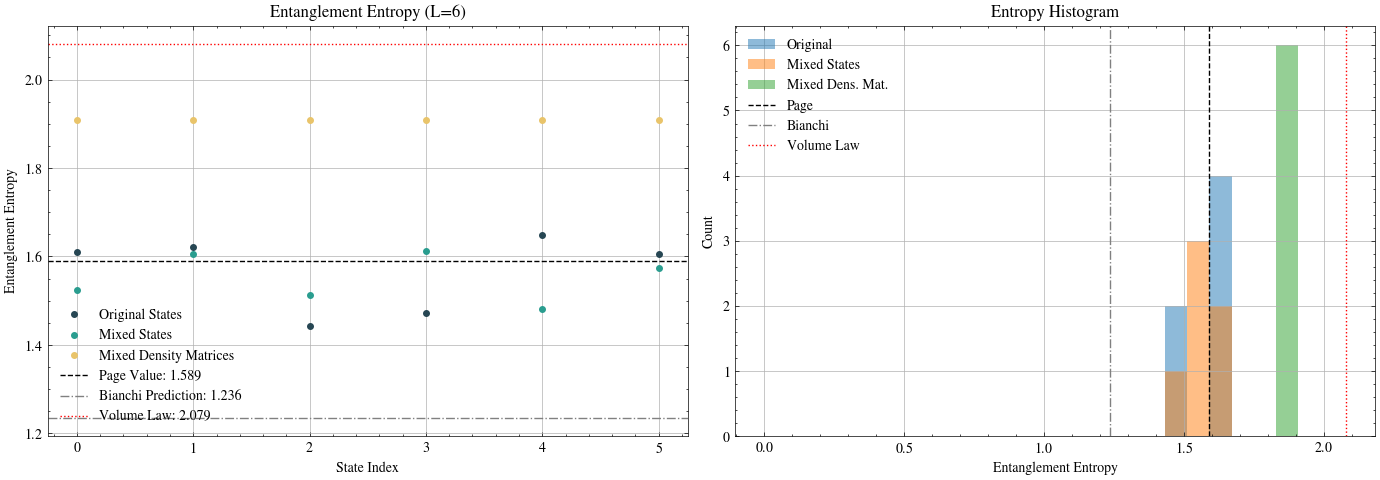

In [69]:
page_value          = EntropyPredictions.Mean.page(da = config["BIPARTITION"]["dimA"], db = config["BIPARTITION"]["dimB"])
gaussian_value      = EntropyPredictions.Mean.random_gaussian_th(L=config["ENV"]["Ns"], f=config["BIPARTITION"]["f"])
volume_value        = np.log(2) * config["BIPARTITION"]["f"] * config["ENV"]["Ns"]  # Volume law prediction
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={"width_ratios": [1, 1]})

# Extract values
vals_original       = np.asarray(entropies["original"].values)
vals_mix_states     = np.asarray(entropies["mix_states"].values)
vals_mix_dens       = np.asarray(entropies["mix_dens_mat"].values)

# Left: line plot
axs[0].plot(vals_original, 'o', label='Original States', markersize=4)
axs[0].plot(vals_mix_states, 'o', label='Mixed States', markersize=4)
axs[0].plot(vals_mix_dens, 'o', label='Mixed Density Matrices', markersize=4)
axs[0].axhline(page_value, color='black', linestyle='--', label=f'Page Value: {page_value:.3f}')
axs[0].axhline(gaussian_value, color='gray', linestyle='-.', label=f'Bianchi Prediction: {gaussian_value:.3f}')
axs[0].axhline(volume_value, color='red', linestyle=':', label=f'Volume Law: {volume_value:.3f}')
axs[0].set_xlabel('State Index')
axs[0].set_ylabel('Entanglement Entropy')
axs[0].set_title(f'Entanglement Entropy (L={L})')
axs[0].legend()
axs[0].grid()

# Right: histogram
all_vals = [
    (vals_original, "Original"),
    (vals_mix_states, "Mixed States"),
    (vals_mix_dens, "Mixed Dens. Mat.")
]
colors = ['tab:blue', 'tab:orange', 'tab:green']
bins = np.linspace(0, max([v.max() for v, _ in all_vals]), 25)

for (vals, label), color in zip(all_vals, colors):
    axs[1].hist(vals, bins=bins, alpha=0.5, label=label, color=color)

axs[1].axvline(page_value, color='black', linestyle='--', label='Page')
axs[1].axvline(gaussian_value, color='gray', linestyle='-.', label='Bianchi')
axs[1].axvline(volume_value, color='red', linestyle=':', label='Volume Law')
axs[1].set_xlabel('Entanglement Entropy')
axs[1].set_ylabel('Count')
axs[1].set_title('Entropy Histogram')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

### Define the loss functions


In [18]:
def normalize_state(c):
    return c / jnp.linalg.norm(c)

def loss_entanglement_unitary(unitary: jnp.array, prepared_states: jnp.array):
    new_states          = prepared_states @ unitary
    dim_a               = config["BIPARTITION"]["dimA"]
    dim_b               = config["BIPARTITION"]["dimB"]
    schmidt_values      = jnp.array([schmidt_jax(state, dim_a, dim_b, use_eig=False)[0] for state in new_states.T])
    entropies           = [vn_entropy_jax(s) for s in schmidt_values]
    return jnp.mean(jnp.array(entropies))

def loss_entanglement_single(coefficients: jnp.array, prepared_states: jnp.array):
    """
    Loss function for a vector of coefficients applied to prepared states.
    """
    dim_a               = config["BIPARTITION"]["dimA"]
    dim_b               = config["BIPARTITION"]["dimB"]
    # compute mixed state vector consisting of \sum _i c_i |psi_i>
    mixed_state         = prepared_states @ coefficients
    # normalize the mixed state
    mixed_state         = normalize_state(mixed_state)
    # compute the Schmidt values and entropy
    schmidt_values, _   = schmidt_jax(mixed_state, dim_a, dim_b, use_eig=False)
    entropy             = vn_entropy_jax(schmidt_values)
    return entropy

loss_entanglement_single_jit    = jax.jit(loss_entanglement_single)
loss_entanglement_unitary_jit   = jax.jit(loss_entanglement_unitary)


### Create standard gradient descent optimizer that minimizes the entanglement entropy

In [19]:
@jax.jit
def step_simple(coeffs, prepared_states, lr = 0.01):
    loss_fn     = lambda c: loss_entanglement_single_jit(c, prepared_states)
    loss        = loss_fn(coeffs)
    grad        = jax.grad(loss_fn)(coeffs)
    coeffs_new  = coeffs - lr * grad
    return normalize_state(coeffs_new), loss


@jax.jit
def step_simple_realimag(coeffs, prepared_states, lr):
    def loss_wrapped(real_imag, prepared_states):
        # Reconstruct complex coefficients
        c           = real_imag[:real_imag.size//2] + 1j * real_imag[real_imag.size//2:]
        return loss_entanglement_single_jit(c, prepared_states)
    
    real_imag   = jnp.concatenate([jnp.real(coeffs), jnp.imag(coeffs)])
    grad        = jax.grad(loss_wrapped)(real_imag, prepared_states)

    # Gradient descent in real+imag space
    updated     = real_imag - lr * grad
    c_new       = updated[:coeffs.size] + 1j * updated[coeffs.size:]
    return normalize_state(c_new), loss_entanglement_single_jit(c_new, prepared_states)

def optimize_simple(prepared_states, lr = 0.01, n_steps = 500, seed = master_seed, is_cpx_simple = iscpx, verbose_every = 50):
    """
    Simple optimization loop for the coefficients.
    
    Parameters:
    - prepared_states: JAX array of prepared states.
    - lr: Learning rate for the optimization.
    - n_steps: Number of optimization steps.
    - seed: Random seed for reproducibility.
    
    Returns:
    - Final coefficients and loss history.
    """
    if is_cpx_simple:
        dtype_in        = jnp.complex64
        key_re, key_im  = jax.random.split(jax.random.PRNGKey(seed))
        # simple random coefficients for complex case
        coeffs_re       = jax.random.normal(key_re, (prepared_states.shape[1],), dtype=dtype_in)
        coeffs_im       = jax.random.normal(key_im, (prepared_states.shape[1],), dtype=dtype_in)
        coeffs          = coeffs_re + 1j * coeffs_im
    else:
        dtype_in        = jnp.float32
        key             = jax.random.PRNGKey(seed)
        coeffs          = jax.random.normal(key, (prepared_states.shape[1],), dtype=dtype_in)
    # ensure the coefficients are normalized
    coeffs          = normalize_state(coeffs)
    losses          = []

    if is_cpx_simple:
        for step in range(n_steps):
            coeffs, loss    = step_simple_realimag(coeffs, prepared_states, lr)
            losses.append(loss)
            
            if step % verbose_every == 0:
                logger.info(f"Step {step}, Loss: {loss:.4f}")
    else:
        for step in range(n_steps):
            coeffs, loss    = step_simple(coeffs, prepared_states, lr)
            losses.append(loss)
            
            if step % verbose_every == 0:
                logger.info(f"Step {step}, Loss: {loss:.4f}")
    
    return coeffs, losses

In [20]:
coeffs, loss = optimize_simple(mainifold_mix_st_jax, lr=0.01, n_steps=2000, seed=master_seed, is_cpx_simple=iscpx, verbose_every=100)
logger.info(f"Final coefficients: {coeffs}")

29_07_2025_18-31_08 [INFO] Step 0, Loss: 1.5498
29_07_2025_18-31_09 [INFO] Step 100, Loss: 1.3283
29_07_2025_18-31_09 [INFO] Step 200, Loss: 1.2734
29_07_2025_18-31_09 [INFO] Step 300, Loss: 1.2594
29_07_2025_18-31_09 [INFO] Step 400, Loss: 1.2559
29_07_2025_18-31_09 [INFO] Step 500, Loss: 1.2548
29_07_2025_18-31_09 [INFO] Step 600, Loss: 1.2545
29_07_2025_18-31_10 [INFO] Step 700, Loss: 1.2543
29_07_2025_18-31_10 [INFO] Step 800, Loss: 1.2543
29_07_2025_18-31_10 [INFO] Step 900, Loss: 1.2543
29_07_2025_18-31_10 [INFO] Step 1000, Loss: 1.2542
29_07_2025_18-31_10 [INFO] Step 1100, Loss: 1.2542
29_07_2025_18-31_10 [INFO] Step 1200, Loss: 1.2542
29_07_2025_18-31_10 [INFO] Step 1300, Loss: 1.2542
29_07_2025_18-31_11 [INFO] Step 1400, Loss: 1.2542
29_07_2025_18-31_11 [INFO] Step 1500, Loss: 1.2542
29_07_2025_18-31_11 [INFO] Step 1600, Loss: 1.2542
29_07_2025_18-31_11 [INFO] Step 1700, Loss: 1.2542
29_07_2025_18-31_11 [INFO] Step 1800, Loss: 1.2542
29_07_2025_18-31_11 [INFO] Step 1900, Loss:

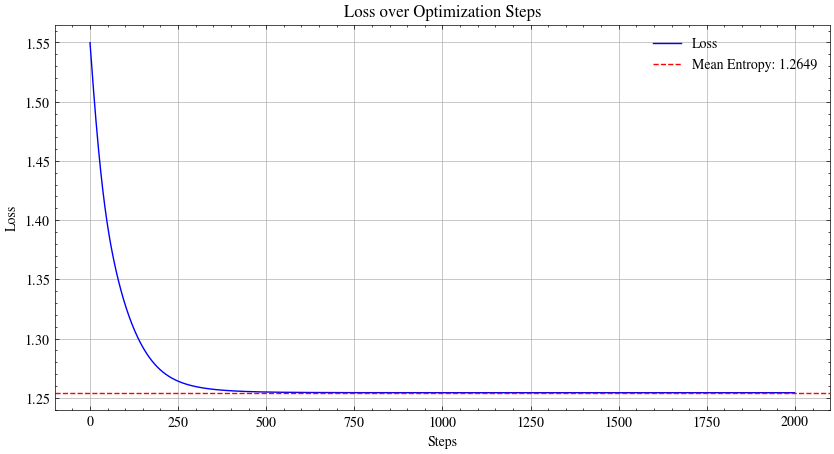

In [21]:

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Loss', color='blue')
plt.axhline(np.min(loss), color='red', linestyle='--', label=f'Mean Entropy: {np.mean(loss):.4f}')
plt.title('Loss over Optimization Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [22]:
# check the final energy of the mixed state
final_mixed_state = mainifold_mix_st_jax @ coeffs
final_energy = jnp.vdot(final_mixed_state, hamil @ final_mixed_state)
logger.info(f"Final energy of the mixed state: {final_energy:.6f}, while was - {manifold}")

29_07_2025_18-31_14 [INFO] Final energy of the mixed state: -1.767666, while was - -1.767666


### Create standard gradient descent optimizer that minimizes the entanglement entropy using density matrices

### Reinforcement learning optimizer for the entanglement entropy

In [ ]:
class QuantumEntanglementEnv(gym.Env):
    """
    A gymnasium.Env for minimizing entanglement entropy.

    - Observation   : Flattened complex unitary matrix V (real and imag parts concatenated).
    - Action        : A discrete integer mapping to a specific Givens rotation (i, j, angle_idx).
    - Reward        : The reduction in total entanglement entropy from the previous step.
    """
    metadata        = {'render_modes': ['human'], 'render_fps': 4}
    
    @dataclass
    class ActionState:
        i           : int
        j           : int
        cos_theta   : float
        sin_theta   : float
        e_iphi      : float = 1.0  # e^(i * phi), default to 1.0 if phi is not used
    
    @staticmethod
    def _apply_rotation_angles(coefficients     : jnp.ndarray,
                            i                   : int,
                            j                   : int,
                            cos_t               : float,
                            sin_t               : float,
                            e_iphi              : float = 1.0):
        c_i, c_j        = coefficients[i], coefficients[j]
        c_i_new         = cos_t * c_i - sin_t * e_iphi * c_j
        c_j_new         = sin_t * jnp.conj(e_iphi) * c_i + cos_t * c_j
        coefficients    = coefficients.at[i].set(c_i_new)
        coefficients    = coefficients.at[j].set(c_j_new)
        return coefficients

    @staticmethod
    def _apply_rotation(coefficients    : jnp.ndarray,
                        i               : int,
                        j               : int,
                        theta           : float,
                        phi             : float = 0.0):
        c_i, c_j        = coefficients[i], coefficients[j]
        cos_t, sin_t    = jnp.cos(theta), jnp.sin(theta)
        e_iphi          = jnp.exp(1j * phi) if phi != 0.0 else 1.0
        return QuantumEntanglementEnv._apply_rotation_angles(coefficients, i, j, cos_t, sin_t, e_iphi)

    def __init__(self,
                config              : dict,
                train_states        : jnp.ndarray,                                      # States to train on (shape: [dim_a * dim_b, Gamma])
                org_states          : Optional[jnp.ndarray]                 = None,     # Original states in the environment (shape: [dim_a * dim_b, Gamma]) - only Gamma matters for us
                K                   : int                                   = 10,       # Discrete action space size
                max_steps           : int                                   = 1000,     # Maximum number of steps in the environment
                reg_lambda_norm     : float                                 = 0.1,
                phase_angles        : Optional[Union[List, np.ndarray]]     = None,
                dtype               : jnp.dtype                             = dtype_jax,# Data type for JAX arrays (complex or real)
                ):     # Regularization parameter for norm penalty
        
        # Initialize the environment with the given parameters.
        super().__init__()
        
        # Validate the input parameters
        la_in                       = config.get("BIPARTITION", {}).get("La", None)
        lb_in                       = config.get("BIPARTITION", {}).get("Lb", None)

        if not isinstance(la_in, int) or la_in <= 0:
            raise ValueError("dim_a must be a positive integer.")
        if not isinstance(lb_in, int) or lb_in <= 0:
            raise ValueError("dim_b must be a positive integer.")
        if not isinstance(K, int) or K <= 0:
            raise ValueError("K must be a positive integer.")
        if not isinstance(train_states, jnp.ndarray) or train_states.ndim != 2:
            raise ValueError("train_states must be a 2D JAX array (shape: [dim_a * dim_b, Gamma]).")
        
        #!TODO: Modify this so we can use masks rather than subsystem A and B on the left and right
        self.dtype                      = dtype_jax if dtype is None else dtype                     # Data type for JAX arrays (complex or real)
        self.iscomplex                  = (self.dtype == jnp.complex128) or (self.dtype == jnp.complex64)
        self.org_states                 = org_states if org_states is not None else train_states    # Use train_states if org_states is None
        self.gamma_dim                  = train_states.shape[1]                                     # Number of coefficients (Gamma) in the environment
        self.full_nh                    = train_states.shape[0]                                     # Full Hilbert space dimension (dim_a * dim_b)
        self.ns                         = int(np.log2(self.full_nh))                                # Number of qubits (log2 of full Hilbert space dimension)        
        self.dim_a                      = 2**la_in                                                  # Dimension of subsystem A (left partition) 
        self.dim_b                      = 2**lb_in                                                  # Dimension of subsystem B (right partition)\
        self.la                         = la_in                                                     # Number of qubits in subsystem A
        self.lb                         = lb_in                                                     # Number of qubits in subsystem B
        self.train_states               = train_states.astype(dtype_jax)                            # States to train on (shape: [dim_a * dim_b, Gamma])
        
        # environment parameters
        self.max_steps                  = max_steps                                                 # Maximum number of steps in the environment
        self.reg_lambda_norm            = reg_lambda_norm                                           # Regularization parameter for norm penalty
        self.train_states_learn         = jnp.array(self.train_states, dtype=self.dtype)            # States to learn on (shape: [dim_a * dim_b, Gamma])
        
        # some entropy predictions
        self.page_value                 = EntropyPredictions.Mean.page(da=self.dim_a, db=self.dim_b)
        self.gaussian_value             = EntropyPredictions.Mean.random_gaussian_th(L=self.ns, f=self.la / self.ns)
        self.volume_value               = np.log(2) * (self.la / self.ns)

        # Define the discrete action space for rotations on Gamma coefficients
        self._delta_theta               = jnp.pi / (2 * K) if K > 0 else 0
        self._phase_angles              = phase_angles or [0.0]

        self.action_map : List[QuantumEntanglementEnv.ActionState] = []
        for i, j in it.combinations(range(self.Gamma), 2):
            for angle_idx in range(-K, K + 1):
                theta = angle_idx * self._delta_theta
                for phi in self._phase_angles:
                    e_iphi = jnp.exp(1j * phi)
                    self.action_map.append(QuantumEntanglementEnv.ActionState(i=i, j=j,
                        cos_theta=jnp.cos(theta), sin_theta=jnp.sin(theta), e_iphi=e_iphi))

        # Define Gym spaces
        self.action_space               = gym.spaces.Discrete(len(self.action_map))                 # Discrete action space for Givens rotations
        self.observation_space          = gym.spaces.Box(low=-1.0, high=1.0, shape=(2 * self.Gamma,), dtype=np.float32)
        self.givens_fun                 = QuantumEntanglementEnv._apply_rotation_angles
        self.uniform_coeffs             = jnp.ones((self.Gamma,), dtype=self.dtype) / jnp.sqrt(self.Gamma)
        self.coefficients               = jnp.array(self.uniform_coeffs, dtype=self.dtype)          # Initial coefficients for the environment

        # Environment state variables
        self.step_count                 = 0                                                         # Step counter - tracks the number of steps taken in the environment
        self.config                     = config                                                    # Configuration dictionary for the environment
        self.org_states_info            = {}                                                        # Information about the original states (entropies, min, max, etc.)
    
    #############################################
    #! Properties
    #############################################
    
    @property
    def Gamma(self) -> int:
        '''
        Returns the number of coefficients (Gamma) in the environment.
        Returns:
            int: The number of coefficients (Gamma).
        '''
        return self.gamma_dim

    @property
    def s(self) -> jnp.ndarray:
        return self.train_states_learn
    
    @property
    def c(self) -> jnp.ndarray:
        return self.coefficients
    
    #############################################
    #! Calculators
    #############################################
    
    @staticmethod
    def _compute_entropy(coefficients : jnp.ndarray, states : jnp.ndarray):
        entropy = loss_entanglement_single_jit(coefficients, states)
        return entropy

    def _reset_states_info(self):
        '''
        Resets the original states information to an empty state.
        This method is used to clear the original states information when resetting the environment.
        '''
        self.org_states_info = {
            'original'          : [],                               # Original states entropies
            'minimum'           : float('inf'),                     # Minimum entropy of original states
            'maximum'           : float('-inf'),                    # Maximum entropy of original states
            'average'           : 0.0,                              # Average entropy of original states
            'mixed'             : [],                               # Mixed states entropies
            'minimum_mixed'     : float('inf'),                     # Minimum entropy of mixed states                                 
            'maximum_mixed'     : float('-inf'),                    # Maximum entropy of mixed states
            'average_mixed'     : 0.0,
            'submanifold_mp'    : np.zeros((self.Gamma,), dtype=int)# Submanifold mapping for entropy values
        }
        
        # go through the original states and calculate the entropies
        for g in range(self.Gamma):
            state               = self.train_states[:, g]
            schmidt_values, _   = schmidt_jax(state, self.dim_a, self.dim_b, use_eig=False)
            entropy             = vn_entropy_jax(schmidt_values)
            
            #! fill up the mixed states info if it is empty
            self.org_states_info['mixed'].append(entropy)
            self.org_states_info['minimum_mixed']   = min(self.org_states_info['minimum_mixed'], entropy)
            self.org_states_info['maximum_mixed']   = max(self.org_states_info['maximum_mixed'], entropy)
            self.org_states_info['average_mixed']  += entropy / self.Gamma
            
            state               = self.org_states[:, g]
            schmidt_values, _   = schmidt_jax(state, self.dim_a, self.dim_b, use_eig=False)
            entropy             = vn_entropy_jax(schmidt_values)
            
            #! fill out the original states info if it is empty
            self.org_states_info['original'].append(entropy)
            self.org_states_info['minimum']         = min(self.org_states_info['minimum'], entropy)
            self.org_states_info['maximum']         = max(self.org_states_info['maximum'], entropy)
            self.org_states_info['average']        += entropy / self.Gamma
    
    #############################################
    #! Environment API Methods
    #############################################

    def reset(self, seed: int = None, options: Dict = None):
        '''
        Resets the environment to an initial state.
        Parameters:
            seed (int, optional):
                Random seed for reproducibility. If None, a random seed will be generated.
            options (Dict, optional):
                Additional options for resetting the environment (not used in this implementation).
        Returns:
            obs (np.ndarray):
                The initial observation of the environment, which is a flattened array of the real and imaginary parts of the coefficients.
            info (Dict):
                Additional information about the reset state, such as the initial loss value.
        Raises:
            ValueError:
                If the initial coefficients do not match the expected shape or norm.
        '''
        super().reset(seed=seed)
        
        # The agent's state V is a ΓxΓ identity matrix
        self.step_count                 = 0

        if len(self.org_states_info) == 0:
            self._reset_states_info() # Reset the original states info if it is empty
        
        self.coefficients               = self.uniform_coeffs.copy()
        entropy                         = self._compute_entropy(self.c, self.s)
        
        # set the observation
        obs                             = jnp.concatenate([jnp.real(self.c), jnp.imag(self.c)]).astype(jnp.float32)
        info                            = { 'entropy' : entropy }
        return np.array(obs), info

    def step(self, action: int):
        """Performs one step in the environment."""
        
        # Update the step count
        self.step_count        += 1
        
        # Action parameters are for a rotation in given (i, j) subspace
        action_params           = self.action_map[action]
        i, j, cos_t, sin_t, e_p = action_params.i, action_params.j, action_params.cos_theta, action_params.sin_theta, action_params.e_iphi
        
        # Build new coefficients
        self.coefficients       = self.givens_fun(self.c, i, j, cos_t, sin_t, e_p)

        # Calculate new entropy using the black-box function
        new_entropy             = self._compute_entropy(self.c, self.s)
        entropy_reduction       = -new_entropy
        normalized_reward       = entropy_reduction / self.volume_value
        reward_entropy          = normalized_reward
        
        # Overlaps with the original states
        # overlaps            = jax.vmap(jnp.vdot, in_axes=(1, 1))(self.org_states, self.transformed_states)
        # overlap_penalty     = jnp.mean(jnp.abs(overlaps)**2)
        overlap_penalty         = 0.0 # Overlap penalty is not used in this implementation, but can be added if needed
        reward_entropy         -= self.reg_lambda_norm * overlap_penalty # Regularization term to penalize overlaps

        terminated              = False
        truncated               = self.step_count >= self.max_steps

        obs                     = jnp.concatenate([jnp.real(self.c), jnp.imag(self.c)]).astype(jnp.float32)
        info                    = { 'entropy' : new_entropy }
        return np.array(obs), float(reward_entropy), terminated, truncated, info

In [39]:
from typing import NamedTuple, Sequence

class ActorCritic(nn.Module):
    """
    State-of-the-art Actor-Critic for PPO adapted to quantum control tasks.

    Policy: Gaussian distribution \(\pi_\theta(a|s)=\mathcal{N}(a; \mu_\theta(s), \mathrm{diag}(\sigma^2))\)
    Value: \(V_\phi(s)\)
    """
    action_dim: int

    @nn.compact
    def __call__(self, x: jnp.ndarray):
        
        x = nn.Dense(128)(x)
        x = nn.LayerNorm()(x)
        x = nn.tanh(x)

        x = nn.Dense(128)(x)
        x = nn.LayerNorm()(x)
        x = nn.tanh(x)
        
        # --- Actor Head ---
        logits = nn.Dense(self.action_dim, kernel_init=nn.initializers.orthogonal(0.01), name="actor_logits")(x)

        # --- Critic Head ---
        # v = nn.Dense(128)(x)
        # v = nn.LayerNorm()(v)
        # v = nn.tanh(v)

        # v = nn.Dense(128)(v)
        # v = nn.LayerNorm()(v)
        # v = nn.tanh(v)
        
        v = nn.Dense(1, kernel_init=nn.initializers.orthogonal(1.0), name="critic_value")(x)
        return logits, v.squeeze(-1)

class Transition(NamedTuple):
    done        : jnp.ndarray
    action      : jnp.ndarray
    value       : jnp.ndarray
    reward      : jnp.ndarray
    log_prob    : jnp.ndarray
    obs         : jnp.ndarray


In [47]:
class PPOAgent:
    '''
    Proximal Policy Optimization (PPO) Agent for Quantum Entanglement Minimization.
    This agent uses an Actor-Critic architecture to learn a policy that minimizes entanglement entropy in a quantum system.
    Attributes:
        obs_shape (Sequence[int]):
            The shape of the observation space, which is used to initialize the actor-critic network.
        action_dim (int):
            The dimension of the action space, which determines the output size of the actor's head in the network.
        config (Dict):
            Configuration dictionary containing hyperparameters for the agent, such as learning rate, optimizer, and GAE parameters.
    '''
    
    def __init__(self, obs_shape: Sequence[int], action_dim: int, config: Dict, dtype = jnp.float32):
        
        self.iscomplex      = (dtype == jnp.complex128) or (dtype == jnp.complex64)         # Check if the dtype is complex
        self.config         = config
        self.obs_shape      = obs_shape
        self.action_dim     = action_dim
        self.key            = jax.random.PRNGKey(config["SEED"])
        
        # Config info
        self.lr             = config.get("LEARNING_RATE", 3e-4)                             # Learning rate for the optimizer
        self.optimizer      = config.get("OPTIMIZER", optax.adam(learning_rate=self.lr))
        self.maxgrad_norm   = config.get("MAX_GRAD_NORM", 0.5)
        self.gamma          = config.get("GAMMA", None)
        self.gae_lambda     = config.get("GAE_LAMBDA", 0.95)
        self.clip_eps       = config.get("CLIP_EPS", 0.2)
        self.ent_coef       = config.get("ENT_COEF", 0.01)                                   # Coefficient for entropy loss
        self.vf_coef        = config.get("VF_COEF", 0.5)
        self.epochs         = config.get("UPDATE_EPOCHS", 4)
        self.gamma_disc     = config.get("GAMMA_DISC", 0.99)                                       # Discount factor for rewards
        if self.gamma is None:
            exit(-1)
        
        # Initialize the actor-critic network
        self.train_state    = None
        self.network        = ActorCritic(action_dim=self.action_dim)
        try:
            self._init_agent()
        except Exception as e:
            exit(-1)

    def _init_agent(self):
        """Initializes the network parameters and the optimizer train state."""
        self.key, network_key   = jax.random.split(self.key)                                # Split the key for network initialization
        init_obs                = jnp.zeros((1, *self.obs_shape))                           # Initial observation for network initialization
        network_params          = self.network.init(network_key, init_obs)["params"]

        tx                      = optax.chain(optax.clip_by_global_norm(self.maxgrad_norm), self.optimizer)
        self.train_state        = TrainState.create(apply_fn=self.network.apply, params=network_params, tx=tx)

    #############################
    #! Agent API Methods
    #############################

    def get_action(self, obs: np.ndarray):
        logits, value       = self.network.apply({'params': self.train_state.params}, obs[None, :])
        logits, value       = logits[0], value[0]
        self.key, subkey    = jax.random.split(self.key)
        action              = jax.random.categorical(subkey, logits)
        log_prob            = jax.nn.log_softmax(logits)[action]
        return int(action), float(log_prob), float(value)

    def update(self, transitions: Transition, last_obs: Optional[np.ndarray] = None):
        """Updates the agent's parameters using a batch of transitions."""
        
        advs, returns = self._calculate_gae(transitions, last_obs, self.gamma_disc, self.gae_lambda)
        obs, act, old_logp, old_val = transitions.obs, transitions.action, transitions.log_prob, transitions.value

        def loss_fn(params, obs, act, old_logp, old_val, adv, ret):
            logits, val         = self.network.apply({'params': params}, obs)
            logp_all            = jax.nn.log_softmax(logits)
            logp                = jnp.take_along_axis(logp_all, act[:, None], axis=1).squeeze()
            ratio               = jnp.exp(logp - old_logp)
            adv_norm            = (adv - adv.mean()) / (adv.std() + 1e-8)

            obj                 = jnp.minimum(ratio * adv_norm, jnp.clip(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * adv_norm)
            policy_loss         = -jnp.mean(obj)

            val_pred_clipped    = old_val + jnp.clip(val - old_val, -self.clip_eps, self.clip_eps)
            val_loss            = 0.5 * jnp.mean(jnp.maximum((val - ret) ** 2, (val_pred_clipped - ret) ** 2))

            entropy             = -jnp.mean(jnp.sum(jnp.exp(logp_all) * logp_all, axis=-1))

            total_loss          = policy_loss + self.vf_coef * val_loss - self.ent_coef * entropy
            return total_loss, (policy_loss, val_loss, entropy)

        for _ in range(self.epochs):
            grads, aux          = jax.grad(loss_fn, has_aux=True)(self.train_state.params, obs, act, old_logp, old_val, advs, returns)
            self.train_state    = self.train_state.apply_gradients(grads=grads)
        return aux  # return last loss components


    ############################
    #! Private Methods
    ############################

    @staticmethod
    @jax.jit
    def _calculate_gae(transitions: Transition, last_val: jnp.ndarray, gamma: float = 0.99, gae_lambda: float = 0.95):    
        rewards, values, dones  = transitions.reward, transitions.value, transitions.done
        T                       = rewards.shape[0]
        adv                     = jnp.zeros_like(rewards)
        gae                     = 0.0
        for t in reversed(range(T)):
            mask                = 1.0 - dones[t]
            delta               = rewards[t] + gamma * last_val * mask - values[t]
            gae                 = delta + gamma * gae_lambda * mask * gae
            adv                 = adv.at[t].set(gae)
            last_val            = values[t]
        return adv, adv + values

In [70]:
actions_per_pair                    = 16 # Number of discrete Givens angles per pair

# ─── Configuration ──────────────────────────────────────────────────────────────
config_agent = {
    # ── Reproducibility ─────────────────────────────────────────────────────────
    "SEED"                          : master_seed,

    # ── Environment parameters ──────────────────────────────────────────────────
    "ENV": {
        "NS"                        : config["ENV"]["Ns"],
        "LA"                        : config["BIPARTITION"]["La"],
        "LB"                        : config["BIPARTITION"]["Lb"],
        "NH"                        : config["ENV"]["Nh"],
        "DIM_A"                     : config["BIPARTITION"]["dimA"],
        "DIM_B"                     : config["BIPARTITION"]["dimB"],
        "GAMMA"                     : config["ENV"]["Gamma"],
        "K"                         : actions_per_pair,         # number of discrete Givens angles per pair
        "MAX_STEPS_PER_EPISODE"     : 6,                        # maximum number of steps per episode
    },

    # ── Training loop ───────────────────────────────────────────────────────────
    "TRAIN": {
        "NUM_UPDATES"               : 50,                       # number of updates to perform
        "NUM_STEPS"                 : 256,                      # number of steps to collect before updating the agent
        "UPDATE_EPOCHS"             : 4,
        "MAX_GRAD_NORM"             : 0.5,                      # maximum gradient norm for clipping
    },

    # ── PPO hyper‐parameters ─────────────────────────────────────────────────────
    "PPO": {
        "LEARNING_RATE"             : 1e-4,
        "CLIP_EPS"                  : 0.2,
        "VF_COEF"                   : 0.5,
        "ENT_COEF"                  : 0.01,
        "GAE_LAMBDA"                : 0.95,
        "GAMMA_DISCOUNT"            : 0.99,
        "UPDATE_EPOCHS"             : 4,        # Number of epochs to update the agent per batch
        "SEED"                      : 42,       # Seed for reproducibility, special for the PPO agent
    },
}

# Calculate derived parameters to ensure consistency
total_training_steps        = config_agent["TRAIN"]["NUM_UPDATES"] * config_agent["TRAIN"]["UPDATE_EPOCHS"] * (config_agent["TRAIN"]["NUM_STEPS"] // config_agent["ENV"]["MAX_STEPS_PER_EPISODE"])

# ─── Initialize the environment ────────────────────────────────────────────────
data_org_jax, data_mix_jax, entropy_values = manifold_org_jax, mainifold_mix_st_jax, entropies["mix_states"].values

logger.title("RL Environment for Quantum Entanglement", desired_size=80, fill='#', color='red')
logger.info(f"Initialized environment with parameters: {config_agent['ENV']}", lvl=1, color='green')

# ─── Create the environment ───────────────────────────────────────────────────
logger.info("Initializing the environment...", lvl=1, color='blue')
env = QuantumEntanglementEnv(
    config              = config,
    train_states        = data_mix_jax,
    org_states          = data_org_jax,
    K                   = config_agent["ENV"]["K"],   
    max_steps           = config_agent["ENV"]["MAX_STEPS_PER_EPISODE"],   
    dtype               = dtype_jax,  # Use JAX dtype for consistency
)

ppo_config              = {**config_agent["PPO"], **config_agent["TRAIN"]}
agent                   = PPOAgent(
    obs_shape           = env.observation_space.shape,
    action_dim          = env.action_space.n,
    config              = ppo_config,
    dtype               = jnp.float32
)

29_07_2025_18-57_19 [INFO] ####################RL Environment for Quantum Entanglement####################
29_07_2025_18-57_19 [INFO] 	->Initialized environment with parameters: {'NS': 6, 'LA': 3, 'LB': 3, 'NH': 64, 'DIM_A': 8, 'DIM_B': 8, 'GAMMA': 6, 'K': 16, 'MAX_STEPS_PER_EPISODE': 6}
29_07_2025_18-57_19 [INFO] 	->Initializing the environment...


In [71]:
def run_rollout(env: QuantumEntanglementEnv, agent: PPOAgent, n_steps: int):
    obs_buf, act_buf, logp_buf, val_buf, rew_buf, done_buf = [], [], [], [], [], []
    obs, info = env.reset()

    for _ in range(n_steps):
        action, logp, value = agent.get_action(jnp.array(obs))
        next_obs, reward, terminated, truncated, _ = env.step(action)

        obs_buf.append(obs)
        act_buf.append(action)
        logp_buf.append(logp)
        val_buf.append(value)
        rew_buf.append(reward)
        done_buf.append(float(terminated or truncated))

        obs = next_obs
        if terminated or truncated:
            obs, info = env.reset()

    return Transition(
        obs         = jnp.array(obs_buf),
        action      = jnp.array(act_buf),
        log_prob    = jnp.array(logp_buf),
        value       = jnp.array(val_buf),
        reward      = jnp.array(rew_buf),
        done        = jnp.array(done_buf),
    ), obs

def train_agent(env: QuantumEntanglementEnv, agent: PPOAgent, num_epochs: int, steps_per_epoch: int, logger: Logger):
    
    if not Logger:
        logger = get_global_logger()
    
    # ─── Training Loop ─────────────────────────────────────────────────────────────
    logger.info("Starting training loop...", lvl=1, color='green')
    pbar = tqdm(total=num_epochs, desc="Ent Progress", unit="update", colour='blue')
    pbar.reset()
    pbar.refresh()

    entropies_per_epoch = []
    
    for epoch in range(num_epochs):
        transitions, last_obs   = run_rollout(env, agent, steps_per_epoch)
        _, _, last_val          = agent.get_action(jnp.array(last_obs))
        loss_stats = agent.update(transitions, last_obs=last_val)

        # get the info
        policy_loss, value_loss, entropy = loss_stats
        entropies_per_epoch.append(entropy)
        
        # set the progress bar
        pbar.set_postfix(
            epoch               = epoch + 1,
            policy_loss         = f"{policy_loss:.4f}",
            value_loss          = f"{value_loss:.4f}",
            entropy             = f"{entropy:.4f}",
            steps               = env.step_count,
            avg_entropy         = f"{np.mean(entropies_per_epoch):.4f}",
            min_entropy         = f"{np.min(entropies_per_epoch):.4f}",
            max_entropy         = f"{np.max(entropies_per_epoch):.4f}",
        )
        pbar.update(1)
        
    logger.title("Training Complete", desired_size=80, fill='#', color='green')
    pbar.close()
    return entropies_per_epoch

# ─── Learning Rate Schedule ────────────────────────────────────────────────────
lr_schedule     = optax.warmup_cosine_decay_schedule(
    init_value      =   0.0,
    peak_value      =   1e-4,
    warmup_steps    =   int(total_training_steps * 0.1), # Use 10% of steps to warm up
    decay_steps     =   int(total_training_steps * 0.9)  # Use the rest to decay
)

num_updates                             = config_agent["TRAIN"]["NUM_UPDATES"]
num_steps                               = config_agent["TRAIN"]["NUM_STEPS"]
config_agent["PPO"]["LEARNING_RATE"]    = 3e-4
logger.info(f"Total updates planned: {num_updates}", lvl=2, color='purple')
logger.info(f"Total steps per update: {num_steps}", lvl=3, color='purple')
entropies_per_epoch = train_agent(env, agent, num_epochs=num_updates, steps_per_epoch=num_steps, logger=logger)


29_07_2025_18-57_30 [INFO] 		->Total updates planned: 50
29_07_2025_18-57_30 [INFO] 			->Total steps per update: 256
29_07_2025_18-57_30 [INFO] 	->Starting training loop...


Ent Progress:   0%|          | 0/50 [00:00<?, ?update/s]/home/klimak/libraries/anaconda3/lib/python3.11/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=float64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/klimak/libraries/anaconda3/lib/python3.11/site-packages/jax/_src/ops/scatter.py:137: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


KeyboardInterrupt: 

In [56]:
loss_entanglement_single_jit(env.c, env.s), env.c, jnp.linalg.norm(env.c), env.s.shape, env.s.dtype, env.c.dtype

(Array(1.64299648, dtype=float64),
 Array([0.5334021 , 0.40824829, 0.40824829, 0.40824829, 0.40824829,
        0.22094238], dtype=float64),
 Array(1., dtype=float64),
 (64, 6),
 dtype('float64'),
 dtype('float64'))

NameError: name 'all_entropies' is not defined

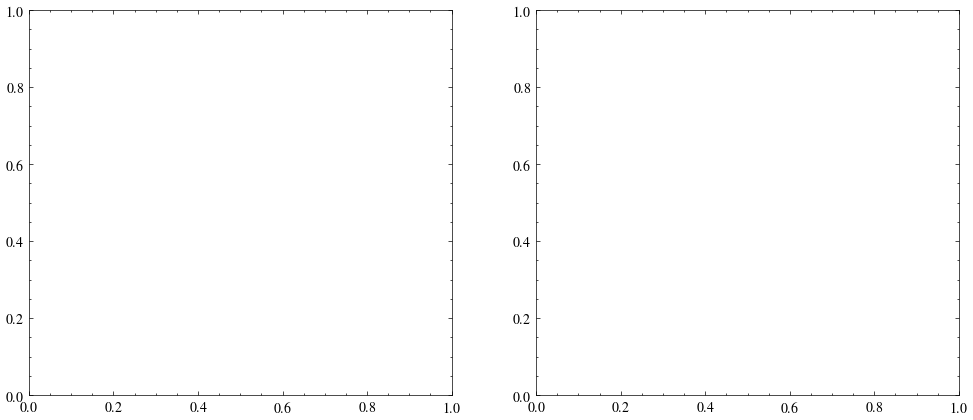

In [51]:
# 3. Plotting Results
fig, ax = Plotter.get_subplots(1, 2, figsize=(12, 5), sharex = True)
ax[0].plot(np.array(all_entropies) / env.Gamma, lw = 0.5)  # Normalize by Gamma to get average entropy per state
ax[0].set_title("Final Entanglement Entropy per Episode")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Average Entanglement Entropy")
ax[0].axhline(y=entropy_values['average'], color='r', linestyle='--', label='Initial Avg Entropy')
ax[0].axhline(y=entropy_values['average_mixed'], color='g', linestyle='--', label='Initial Avg Mixed Entropy')

entropies_final = env.current_entropies
logger.info(f"Final entropies: {entropies_final}", color='blue', lvl=1)
logger.info(f"Submanifold mapping: {env.org_states_info['submanifold_mp']}", color='blue', lvl=1)
for i, e in enumerate(entropies_final):
    logger.info(f"Original state {i}: Entropy = {entropy_values['original'][i]:.3f}, Mixed state {i}: Entropy = {entropy_values['mixed'][i]:.3f}", color='blue', lvl=2)
    ax[0].axhline(y=e, color = 'blue', linestyle=':', alpha=0.5, label=f'$\\Gamma_{i} = {e:.3f}$')
ax[0].legend(frameon=True, loc='upper right')
ax[0].set_yscale('log')  # Use logarithmic scale for better visibility of entropies

ax[1].plot(np.array(all_rewards) - np.min(all_rewards), lw = 0.5)
ax[1].set_title("Approximate Episode Rewards")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Reward")
ax[1].set_yscale('log')  # Use logarithmic scale for better visibility of rewards
fig.tight_layout()